**Imports**

In [136]:
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo 
from sklearn.model_selection import train_test_split, GridSearchCV
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve, average_precision_score, precision_score, recall_score, f1_score
from sklearn.exceptions import DataConversionWarning
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import copy
import warnings

# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

warnings.filterwarnings(action='ignore', category=DataConversionWarning)

**Load data**

In [137]:
# fetch dataset 
statlog_german_credit_data = fetch_ucirepo(id=144) 
  
# data (as pandas dataframes) 
X = statlog_german_credit_data.data.features 
y = statlog_german_credit_data.data.targets 

**Prepare data**

In [158]:
# convert object data type to numericals
for column in X:
    if X[column].dtype == 'object':
        X[column] = X[column].astype('category').cat.codes
        
# split data into train, validation & test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

# get [0,1] labels for xbgoost
y_train_val[y_train_val == 1] = 0
y_train_val[y_train_val == 2] = 1
y_test[y_test == 1] = 0
y_test[y_test == 2] = 1

**Data exploration \(based on training data\)**

In [139]:
# Get data balance
print(f"Data balance:\n  Good: {y_train[y_train == 1].count()}\n  Bad:  {y_train[y_train == 2].count()}")

# Ratio of 2:1 --> Balancing-Methods are not necessarily needed

Data balance:
  Good: class    172
dtype: int64
  Bad:  class    0
dtype: int64


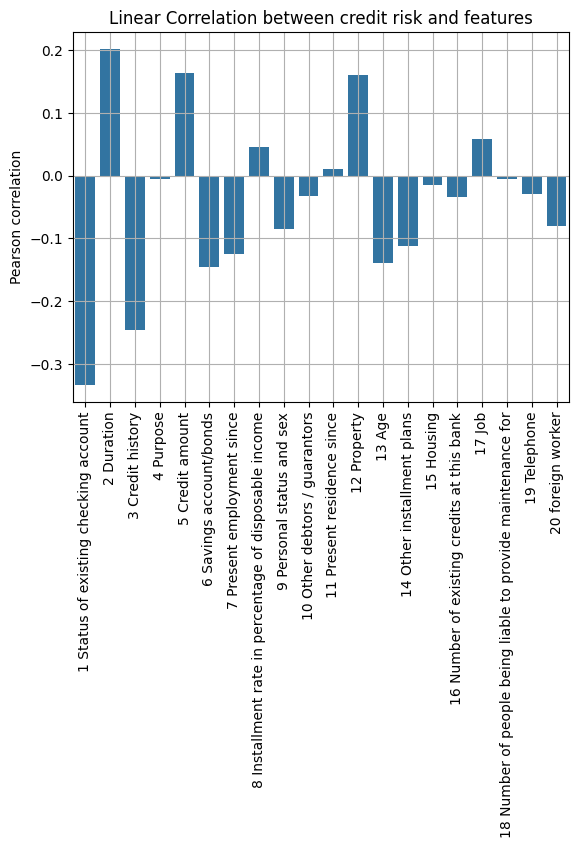

In [140]:
# Do linear correlation assessement
correlation_coef = []
attributes = []
for idx, (column, attribute_name) in enumerate(zip(X_train_val, statlog_german_credit_data.variables.description)):
    correlation_coef.append(X_train_val[column].corr(y_train_val['class']))
    attributes.append(str(idx+1) + " " + attribute_name)

# plot results
sns.barplot(x=attributes, y=correlation_coef)
plt.title('Linear Correlation between credit risk and features')
plt.xticks(rotation = 90)
plt.ylabel('Pearson correlation')
plt.grid()

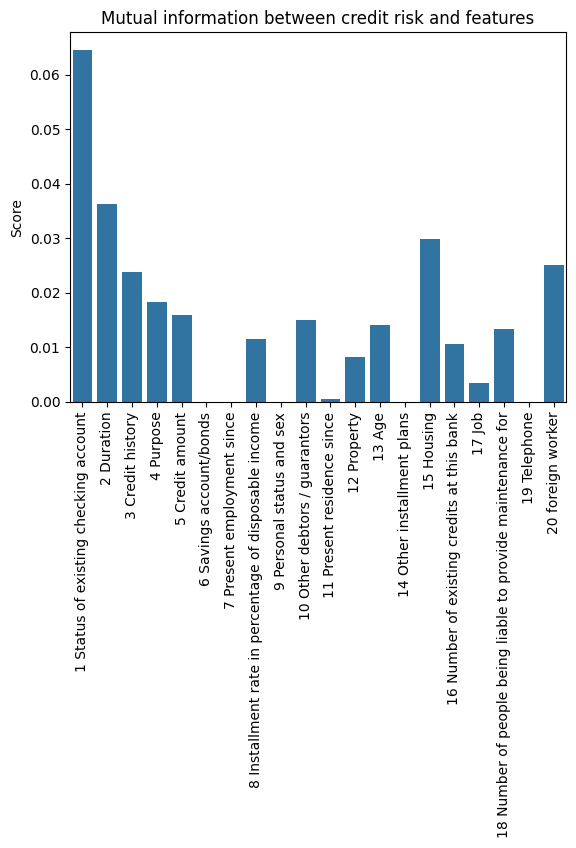

In [141]:
# Nonlinear interactions --> Mutual information
mi = mutual_info_classif(X_train_val, y_train_val["class"], random_state=42)
mi_series = pd.Series(mi, index=X_train_val.columns)

# plot results
sns.barplot(x=attributes, y=mi_series)
plt.title('Mutual information between credit risk and features')
plt.xticks(rotation = 90)
plt.ylabel('Score')
plt.show()

Text(0.5, 1.0, 'Pearson correlation coeeficient of features')

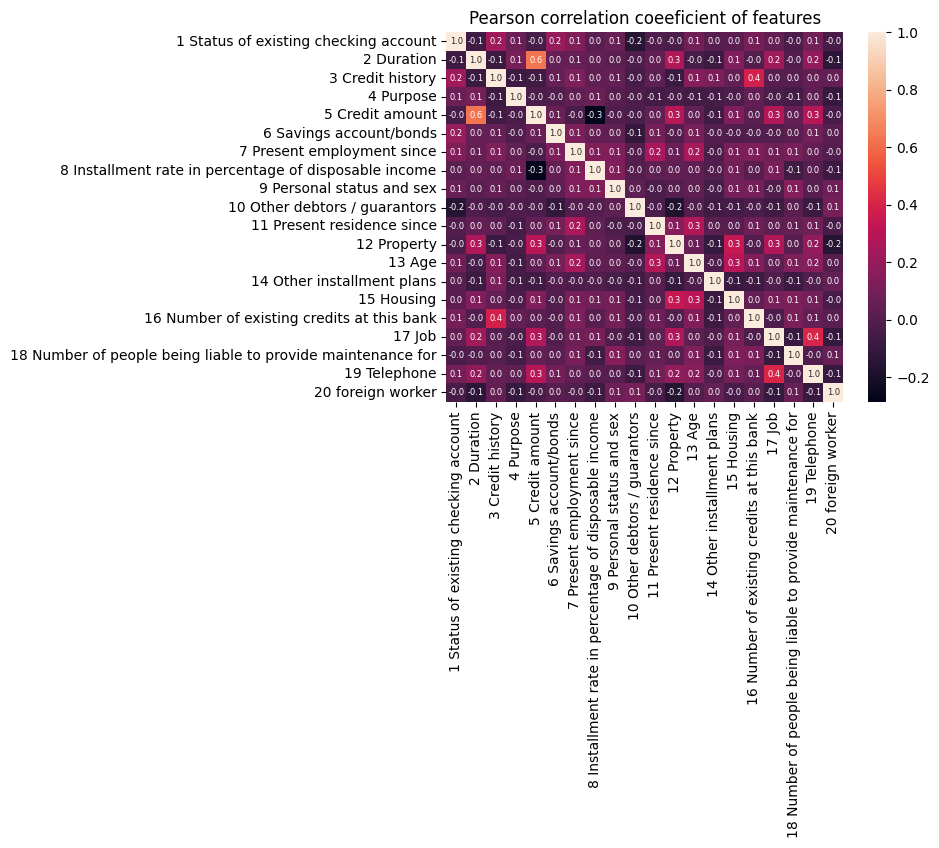

In [142]:
# Feature correlation
feature_corr = X_train_val.corr()

# plot
sns.heatmap(feature_corr, annot=True, fmt=".1f", annot_kws={"size": 6}, xticklabels=attributes,  yticklabels=attributes)
plt.title('Pearson correlation coeeficient of features')

In [143]:
# for future evaluations
X_train_val_original = copy.deepcopy(X_train_val)
X_test_original = copy.deepcopy(X_test)

# remove all features with very low correlation or very low mutual information
for column, coef, mi, attribute in zip(X_train_val, correlation_coef, mi_series, attributes):
    if abs(coef) < 0.03 or mi < 0.005:
        X_train_val.drop(columns=column)
        X_test.drop(columns=column)
        print(column + " - " + attribute + " dropped.")

Attribute4 - 4 Purpose dropped.
Attribute6 - 6 Savings account/bonds dropped.
Attribute7 - 7 Present employment since dropped.
Attribute9 - 9 Personal status and sex dropped.
Attribute11 - 11 Present residence since dropped.
Attribute14 - 14 Other installment plans dropped.
Attribute15 - 15 Housing dropped.
Attribute17 - 17 Job dropped.
Attribute18 - 18 Number of people being liable to provide maintenance for dropped.
Attribute19 - 19 Telephone dropped.


**Choose an adequate model**

In [144]:
# build classifier pipelines
pipelines = {
    'LogisticRegression': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression())
]),
    'KNN': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', KNeighborsClassifier())
    ]),
    'RF': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', RandomForestClassifier())
    ]),
    'SVM': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', SVC())
    ]),
    'XGBoost': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', XGBClassifier())
    ])
}

# build a parameter grid for simple model optimization
param_grids = {
    'LogisticRegression': {
        'clf__C': [0.01, 0.1, 1, 10, 100],        
        'clf__penalty': ['l2'],                   
        'clf__solver': ['lbfgs', 'liblinear']     
    },
    'KNN': {
        'clf__n_neighbors': [3, 5, 7, 9, 11],
        'clf__weights': ['uniform', 'distance'],
        'clf__metric': ['euclidean', 'manhattan']
    },
    'RF': {
        'clf__n_estimators': [50, 100, 200],
        'clf__max_depth': [None, 10, 20, 30],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4],
        'clf__bootstrap': [True, False]
    },
    'SVM': {
        'clf__C': [0.1, 1, 10, 100],
        'clf__kernel': ['linear', 'rbf'],
        'clf__gamma': ['scale', 'auto']  
    },
    'XGBoost': {
        'clf__n_estimators': [100, 200],
        'clf__max_depth': [3, 5, 7],
        'clf__learning_rate': [0.01, 0.1, 0.2],
        'clf__subsample': [0.6, 0.8, 1.0],
        'clf__colsample_bytree': [0.6, 0.8, 1.0]
    }
}

# evaluate scores
scores_mean = []
models = []
names = []
best_params = []
for name, pipeline in pipelines.items():
    
    grid = GridSearchCV(pipeline, param_grids[name], cv=5, scoring='f1')
    grid.fit(X_train_val, y_train_val)
    scores_mean.append(grid.best_score_.mean())
    models.append(grid.best_estimator_)
    best_params.append((name, grid.best_params_))
    names.append(name)
    print(name + ' finished!')

LogisticRegression finished!
KNN finished!
RF finished!
SVM finished!
XGBoost finished!


Best model: XGBoost with f1-Score of: 0.5676534871946954
('XGBoost', {'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.2, 'clf__max_depth': 5, 'clf__n_estimators': 100, 'clf__subsample': 0.6})


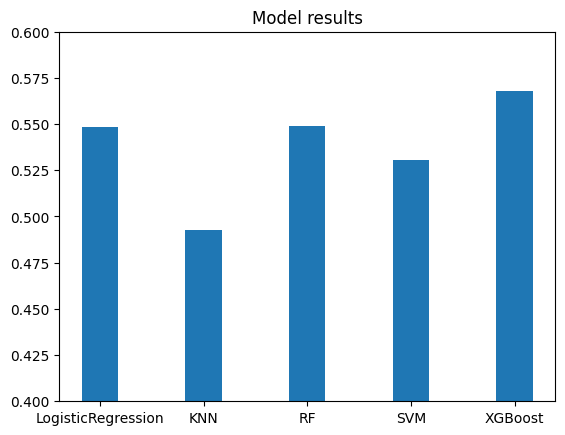

In [145]:
# plot results 
x = np.arange(len(names))  # Positionen auf der x-Achse
width = 0.35  # Breite der Balken

fig, ax = plt.subplots()
f1_bars = ax.bar(x, scores_mean, width, label='F1 Score', capsize=5)
ax.set_title('Model results')
ax.set_xticks(x)
ax.set_xticklabels(names)
ax.set_ylim([0.4, 0.6])

# get the best model
name_best_model = names[np.argmax(scores_mean)]
params_best_model = best_params[np.argmax(scores_mean)]
print('Best model: ' + name_best_model + ' with f1-Score of: ' + str(np.max(scores_mean)))
print(params_best_model)


**Evaluate and tune best model**

Best Threshold: 0.468
Precision: 0.646
Recall: 0.667
F1-Score: 0.656


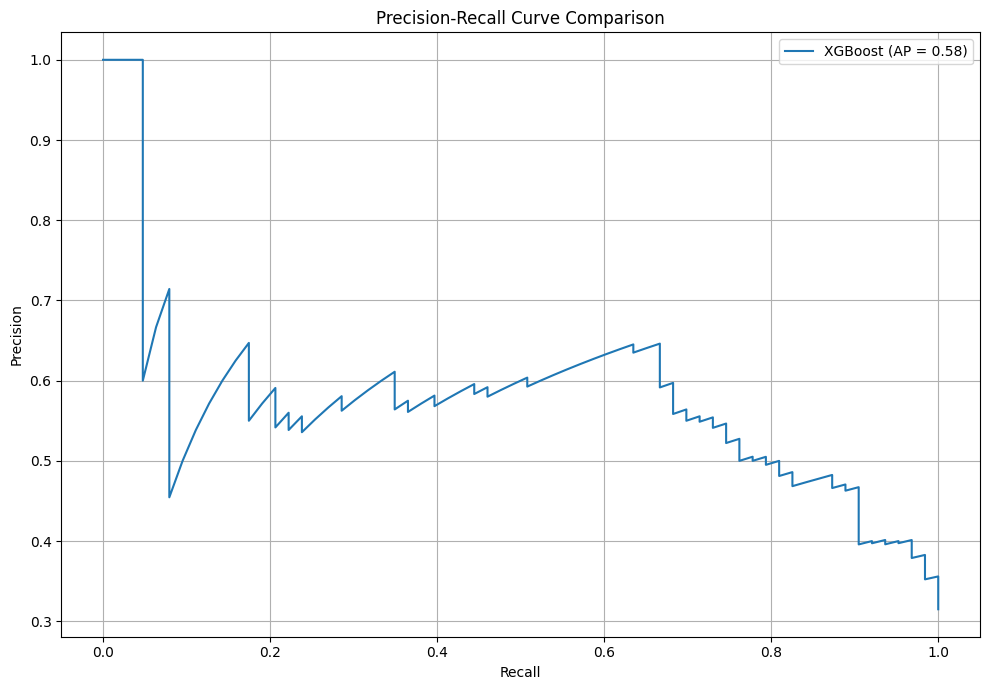

In [146]:
# Precision recall curve
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25)
best_clf = models[names == 'XGBoost']
y_scores = best_clf.predict_proba(X_val)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_val, y_scores)
avg_precision = average_precision_score(y_val, y_scores)

# F1-Score für jeden Threshold berechnen
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)  # +1e-8 vermeidet Division durch 0
best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]

print(f"Best Threshold: {best_threshold:.3f}")
print(f"Precision: {precision[best_idx]:.3f}")
print(f"Recall: {recall[best_idx]:.3f}")
print(f"F1-Score: {f1_scores[best_idx]:.3f}")
   
# plot results
plt.figure(figsize=(10, 7))
plt.plot(recall, precision, label=f'{name} (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


**Final evaluation on test data**

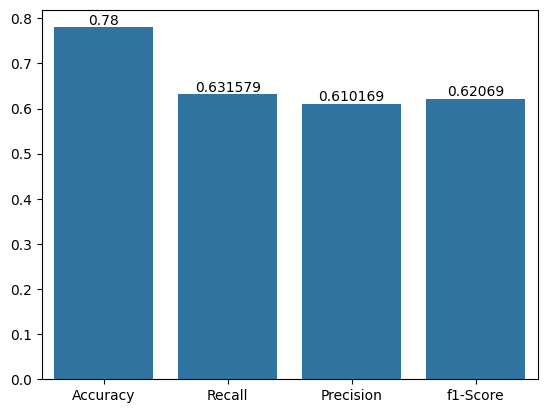

In [147]:
y_pred = (best_clf.predict_proba(X_test)[:,1] >= best_threshold).astype(bool)
final_results = {
    'Accuracy': accuracy_score(y_pred, y_test),
    'Recall': recall_score(y_pred, y_test),
    'Precision': precision_score(y_pred, y_test),
    'f1-Score': f1_score(y_pred, y_test)
}

ax = sns.barplot(final_results)
ax.bar_label(ax.containers[0], fontsize=10);


**Do comparison with entire dataset to validate feature removal**

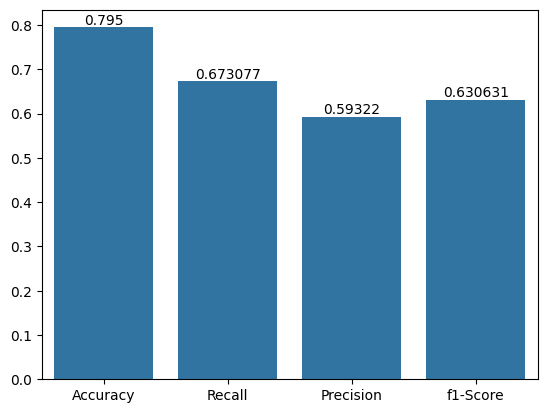

In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', XGBClassifier(n_estimators = 100, subsample = 0.6, learning_rate = 0.2, max_depth = 5, colsample_bytree = 0.8))
])

pipeline.fit(X_train_val_original, y_train_val)
y_pred = (pipeline.predict_proba(X_test)[:,1] >= best_threshold).astype(bool)
final_results = {
    'Accuracy': accuracy_score(y_pred, y_test),
    'Recall': recall_score(y_pred, y_test),
    'Precision': precision_score(y_pred, y_test),
    'f1-Score': f1_score(y_pred, y_test)
}

ax = sns.barplot(final_results)
ax.bar_label(ax.containers[0], fontsize=10);